In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")


GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Before running this notebook:


*   Import Utils folder from Github
*   Set Runtime to use GPU
*   Run code above w/out errors





Dataset Parsing

In [ ]:
import gzip

def read_dataset(file_path):
    # Load the data from the file
    with gzip.open(file_path, 'rb') as f:
        data = f.read()

    # Split the data into lines
    lines = data.strip().split(b'\n')

    # Split the lines into input data and target data
    input_data = []
    target_data = []
    for line in lines:
        # Remove leading and trailing whitespace and split on the tab character
        target_str, input_str = line.strip().split(b'\t', 1)
        input_data.append(input_str.decode('utf-8'))
        target_data.append(target_str.decode('utf-8'))
    #The below line is very important, please do not forget this or colab will not work
    #return input_data[:len(input_data) // 4], target_data[:len(target_data) // 4]
    return input_data[:1000], target_data[:1000]


In [ ]:
############################################################################################

#VOCAB 
def build_vocab(input_data, target_data):
    # Create a set to store the words
    vocab = set()
    vocab.add('<PAD>')
    # Loop over the input data and add the words to the vocab set
    for input_str in input_data:
        for word in input_str.split():
            vocab.add(word)

    # Loop over the target data and add the words to the vocab set
    for target_str in target_data:
        for word in target_str.split():
            vocab.add(word)

    return vocab
############################################################################################
# Word to Index Mappings
def create_word_to_index_mapping(vocab):
    # Sort the vocabulary
    vocab = sorted(vocab)

    # Create a dictionary mapping words to integer indices
    word_to_index = {word: index for index, word in enumerate(vocab)}

    return word_to_index


# Index to Word Mappings
def create_index_to_word_mapping(vocab):
    index_to_word = {}
    for i, word in enumerate(vocab):
        index_to_word[i] = word

    return index_to_word
############################################################################################

#Text to Sequence 
def text_to_sequence(text, word_to_index):
    # Tokenize the text into words
    words = text.split()

    # Map the words to integer indices
    indices = [word_to_index[word] for word in words]

    return indices

############################################################################################

#Sequence to Text
def sequence_to_text(sequence, index_to_word):
    # Map the integer indices to words
    words = [index_to_word[index] for index in sequence]

    # Join the words into a single string
    text = ' '.join(words)

    return text

############################################################################################

#Sequence to sequences of word indices
def sequence_to_sequence_of_word_indices(sequences, word_to_index):
    # Convert the sequences to sequences of word indices
    sequences_indices = [[word_to_index[word] for word in sequence.split()] for sequence in sequences]

    # Determine the maximum sequence length
    max_length = max(len(sequence) for sequence in sequences_indices)

    # Pad the sequences to the same length
    sequences_padded = [sequence + [word_to_index['<PAD>']] * (max_length - len(sequence)) for sequence in sequences_indices]

    return sequences_padded
############################################################################################

Creating The Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint
from torch.utils.tensorboard import SummaryWriter
import pandas as pd


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # split embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        valkeys = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd, nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, head_dim)
        # keys shape: (N, key_len, heads, head_dim)
        # energy: (N, heads, query_len, key_len)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhql, nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, head_dim)
        # after einsum: (N, query_len, heads, head_dim) then flatten last two dimensions

        out = self.fc_out(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout) 
    
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size, heads, dropout=dropout, forward_expansion=forward_expansion
                )
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out 

class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)
        return out
    
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=256,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cuda",
        max_length=100,
    ):
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

   #For Testing the model compilation
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)

    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
    out = model(x, trg[:, :-1])
    print(out.shape)


#print(val_df)

torch.Size([2, 7, 10])


In [ ]:
#DATASET PREPARATION 
from sklearn.model_selection import train_test_split
# Load the data from the file
file_path = '/content/drive/MyDrive/europarl-v10.de-en.tsv.gz'
input_data, target_data = read_dataset(file_path)
print("Input data read. Example: ", input_data[0])
# Split the data into training and validation sets
train_input, val_input, train_target, val_target = train_test_split(input_data, target_data, test_size=0.2)

Input data read. Example:  4. The ratification and implementation of the updated ILO conventions (vote)	ep-09-11-26-008-04.txt	008-04


In [ ]:
print(len(train_input))

800


In [ ]:
# Create a DataFrame with the training data
train_df = pd.DataFrame({'input': train_input, 'target': train_target})

# Print the DataFrame
#print(train_df)

# Create a DataFrame with the validation data
val_df = pd.DataFrame({'input': val_input, 'target': val_target})

# Print the DataFrame (its long)

#build vocab
vocab = build_vocab(train_input + val_input, train_target + val_target)
#word to index mappings
word_to_index = create_word_to_index_mapping(vocab)
index_to_word = create_index_to_word_mapping(vocab)
#text to sequence
train_input_sequences = sequence_to_sequence_of_word_indices(train_input, word_to_index)
train_target_sequences = sequence_to_sequence_of_word_indices(train_target, word_to_index)
val_input_sequences = sequence_to_sequence_of_word_indices(val_input, word_to_index)
val_target_sequences = sequence_to_sequence_of_word_indices(val_target, word_to_index)
#sequence to text is only necessary for sampling
# Convert a sequence of integer indices back into human-readable text
text = sequence_to_text([1, 2, 3], index_to_word)
#print("Demo of sequence to text: ",text)

In [ ]:
print(torch.tensor(train_input_sequences[0]).to(device).shape) #This is essentially what our input tensor will look like

torch.Size([100])


In [ ]:
#Self attention test script
import torch
import torch.nn as nn

# Define a dummy input tensor
batch_size = 2
seq_len = 76
embed_size = 64
heads = 8
x = torch.randn(batch_size, seq_len, embed_size, heads)

# Initialize SelfAttention
selfattn = SelfAttention(embed_size, heads)

# Generate dummy values, keys, and queries
values = keys = queries = torch.randn(batch_size, seq_len, embed_size)

# Set mask to None
mask = None

# Pass the input tensor through SelfAttention
output = selfattn(values, keys, queries, mask)

# Print the output shape
print(output.shape)


torch.Size([2, 76, 64])


In [ ]:
#Encoder Test
import torch

# define hyperparameters
src_vocab_size = 100
embed_size = 64
num_layers = 6
heads = 8
device = torch.device("cuda")
forward_expansion = 4
dropout = 0.1
max_length = 100

# create a dummy input tensor
batch_size = 1
seq_length = 76
dummy_input = torch.randint(low=0, high=src_vocab_size, size=(batch_size, seq_length)).to(device)
mask = torch.ones((batch_size, seq_length)).to(device)

# create an instance of the encoder
encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length).to(device)

# pass the dummy input through the encoder and check the output shape
output = encoder(dummy_input, mask)
print(output.shape)  # expected output: torch.Size([16, 76, 512])



torch.Size([1, 76, 64])


In [ ]:
#Decoder Block Test
import torch
import torch.nn as nn

# Define dummy input tensor
batch_size = 16
seq_length = 76
embed_size = 64
heads = 8
forward_expansion = 4
dropout = 0.2
device = 'cuda'
x = torch.randn(batch_size, seq_length, embed_size).to(device)
value = torch.randn(batch_size, seq_length, embed_size).to(device)
key = torch.randn(batch_size, seq_length, embed_size).to(device)
src_mask = torch.randn(batch_size, 1, seq_length, seq_length).to(device)
trg_mask = torch.randn(batch_size, 1, seq_length, seq_length).to(device)

# Instantiate DecoderBlock
decoder_block = DecoderBlock(embed_size, heads, forward_expansion, dropout, device).to(device)

# Pass input through DecoderBlock
out = decoder_block(x, value, key, src_mask, trg_mask)

# Print output shape
print(out.shape)


torch.Size([16, 76, 64])


In [ ]:
#Decoder Test

import torch
import torch.nn as nn

# Define hyperparameters
trg_vocab_size = 100
embed_size = 64
num_layers = 6
heads = 8
forward_expansion = 4
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length = 100

# Create a dummy input tensor
x = torch.randint(0, trg_vocab_size, size=(64, 10)).to(device)

# Create a dummy encoder output tensor
enc_out = torch.randn(64, 20, embed_size).to(device)

# Create a dummy source and target mask
src_mask = torch.ones(8, 1, 20).to(device)
trg_mask = torch.ones(8, 10, 10).to(device) #Note: If the masks are not constructed properly, everything will break

# Create a decoder instance
decoder = Decoder(
    trg_vocab_size,
    embed_size,
    num_layers,
    heads,
    forward_expansion,
    dropout,
    device,
    max_length
).to(device)

# Pass the input tensor through the decoder
out = decoder(x, enc_out, src_mask, trg_mask)

# Check the output shape
assert out.shape == torch.Size([64, 10, trg_vocab_size])


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda")

# define input tensors
value = torch.randn(8, 10, 64).to(device)
key = torch.randn(8, 10, 64).to(device)
query = torch.randn(8, 10, 64).to(device)
mask = torch.ones(8, 1, 10, 10).to(device)

# initialize transformer block
transformer_block = TransformerBlock(embed_size=64, heads=8, dropout=0.1, forward_expansion=4).to(device)
#Embed_size passed to the block must be the same as initialized in the input tensors above ^^^^^


# pass inputs through transformer block
output = transformer_block(value, key, query, mask)

# check output shape
print(output.shape)  # should be torch.Size([8, 10, 512])


torch.Size([8, 10, 64])


In [ ]:
#Transformer test
import torch
import torch.nn as nn

device = torch.device("cuda")
# Initialize model parameters
src_vocab_size = 100
trg_vocab_size = 100
src_pad_idx = 0
trg_pad_idx = 0
embed_size = 64
num_layers = 6
forward_expansion = 4
heads = 8
dropout = 0
max_length = 100

# Create a sample input
src = torch.randint(low=0, high=src_vocab_size, size=(8, 20)).to(device)
trg = torch.randint(low=0, high=trg_vocab_size, size=(8, 10)).to(device)

# Initialize model
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx,
                    embed_size, num_layers, forward_expansion, heads, dropout, device, max_length).to(device)

print(src.shape)
print(trg.shape)
# Calculate the output
output = model(src, trg[:, :-1])

# Check the shape of the output tensor
#assert output.shape == trg[:, 1:].shape + (trg_vocab_size)

# Test encoder output
src_mask = model.make_src_mask(src)
enc_out = model.encoder(src, src_mask)
assert enc_out.shape == (8, 20, embed_size), f"Expected encoder output shape (8, 20, 256), but got {enc_out.shape}"

# Test decoder output
trg_mask = model.make_trg_mask(trg)
dec_out = model.decoder(trg, enc_out, src_mask, trg_mask)
assert dec_out.shape == (8, 10, 100), f"Expected decoder output shape (8, 10, 150), but got {dec_out.shape}"


torch.Size([8, 20])
torch.Size([8, 10])


In [ ]:
# We're ready to define everything we need for training our Seq2Seq model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device ", device)

load_model = True
save_model = True

# Training hyperparameters
num_epochs = 100
learning_rate = 1e-3
batch_size = 8
val_batch_size = batch_size
num_val_samples = len(val_input_sequences)
num_val_batches = (num_val_samples + val_batch_size - 1) // val_batch_size

# Model hyperparameters
src_vocab_size = len(vocab)
trg_vocab_size = len(vocab)
embed_size = 64
num_heads = 8
num_layers = 6
#num_decoder_layers = 6
dropout = 0.10
max_length = 100
forward_expansion = 4
# Set the source and target padding indices
src_pad_idx = word_to_index['<PAD>']
trg_pad_idx = word_to_index['<PAD>']

# Tensorboard to get nice loss plot
writer = SummaryWriter("runs/loss_plot")
step = 0

model = Transformer(
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    trg_pad_idx,
    embed_size,
    num_layers,
    forward_expansion,
    num_heads,
    dropout,
    device,
    max_length,
).to(device)

# Set the criterion
criterion = torch.nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using device  cuda


In [ ]:
#Debug
# Absolutely huge, run when you restart kernel
train_target_sequences = torch.tensor(train_target_sequences)
train_input_sequences = torch.tensor(train_input_sequences)
test = train_target_sequences[0]
print(test.shape)
#test = test.unsqueeze(0)
test  = test.repeat(8, 1)
print(test.shape)

torch.Size([63])
torch.Size([8, 63])


Training the model...
Epoch:  0 Validation Loss:  7.8590722131729125
Epoch:  0 Loss:  7.277273178100586
Epoch:  1 Loss:  6.944750785827637
Epoch:  2 Loss:  6.748601913452148
Epoch:  3 Loss:  6.585626602172852
Epoch:  4 Loss:  6.4092254638671875
Epoch:  5 Loss:  6.279175758361816
Epoch:  6 Loss:  6.269858360290527
Epoch:  7 Loss:  6.200812816619873
Epoch:  8 Loss:  6.233091831207275
Epoch:  9 Loss:  6.186375141143799
Epoch:  10 Validation Loss:  9.561073586940765
Epoch:  10 Loss:  6.195732593536377
Epoch:  11 Loss:  6.187384605407715
Epoch:  12 Loss:  6.150946617126465
Epoch:  13 Loss:  6.211514472961426
Epoch:  14 Loss:  6.2889275550842285
Epoch:  15 Loss:  6.743457794189453
Epoch:  16 Loss:  6.6832756996154785
Epoch:  17 Loss:  6.65725564956665
Epoch:  18 Loss:  6.653554916381836
Epoch:  19 Loss:  6.651622772216797
Epoch:  20 Validation Loss:  9.998440401554108
Epoch:  20 Loss:  6.3304524421691895
Epoch:  21 Loss:  6.448061943054199
Epoch:  22 Loss:  6.20059871673584
Epoch:  23 Loss: 

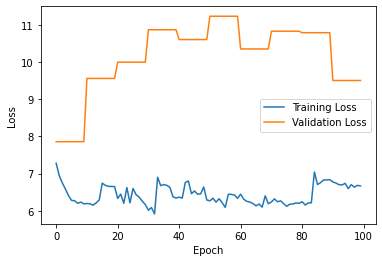

In [ ]:
import matplotlib.pyplot as plt
print('Training the model...')

# Lists to store training and validation losses
train_losses = []
val_losses = []

val_every = 10
for epoch in range(num_epochs):
    # Loop over the training data
    for input_seq, target_seq in zip(train_input_sequences, train_target_sequences):
        # Convert the input and target sequences to tensors and move them to the device
        input_tensor = torch.tensor(input_seq).to(device)
        target_tensor = torch.tensor(target_seq).to(device)
        input_tensor = input_tensor.repeat(batch_size, 1)
        target_tensor = target_tensor.repeat(batch_size, 1)

        # Forward pass
        output = model(input_tensor, target_tensor)

        # Calculate the loss
        loss = criterion(output.view(-1, src_vocab_size), target_tensor.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute validation loss after each epoch
    val_loss = 0.0
    num_val_batches = 0
    # Loop over the validation data
    if epoch % val_every == 0:
      for val_input_seq, val_target_seq in zip(val_input_sequences, val_target_sequences):
          # Convert the validation input and target sequences to tensors and move them to the device
          val_input_tensor = torch.tensor(val_input_seq).to(device)
          val_target_tensor = torch.tensor(val_target_seq).to(device)
          val_input_tensor = val_input_tensor.repeat(val_batch_size, 1)
          val_target_tensor = val_target_tensor.repeat(val_batch_size, 1)

          # Disable gradient calculation during validation
          with torch.no_grad():
              # Forward pass on the validation data
              val_output = model(val_input_tensor, val_target_tensor)

              # Calculate the validation loss
              val_loss += criterion(val_output.view(-1, trg_vocab_size), val_target_tensor.view(-1)).item()
              num_val_batches += 1

      avg_val_loss = val_loss / num_val_batches
      print("Epoch: ", epoch, "Validation Loss: ", avg_val_loss)
    # Append the losses to the lists for plotting
    train_losses.append(loss.item())
    val_losses.append(avg_val_loss)
    print("Epoch: ", epoch, "Loss: ", loss.item())

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Define a function to sample from the model
def sample(model, sentence, src_field, trg_field, max_len=50):
    model.eval()

    # Tokenize the input sentence and convert to indices
    tokens = src_field.tokenize(sentence)
    indices = [src_field.vocab.stoi[token] for token in tokens]
    indices = torch.LongTensor(indices).unsqueeze(1).to(model.device)

    # Forward pass through the model
    with torch.no_grad():
        encoder_outputs, encoder_mask = model.encoder(indices)
        decoder_input = torch.LongTensor([[trg_field.vocab.stoi['<sos>']]]).to(model.device)

        for i in range(max_len):
            decoder_output, _ = model.decoder(decoder_input, encoder_outputs, encoder_mask)
            pred_token = decoder_output.argmax(dim=2)[-1].item()
            decoder_input = torch.cat([decoder_input, torch.LongTensor([[pred_token]])], dim=0)
            if pred_token == trg_field.vocab.stoi['<eos>']:
                break

    # Convert the output indices to tokens and return the sentence
    tokens = [trg_field.vocab.itos[i] for i in decoder_input.squeeze().tolist()]
    return ' '.join(tokens[1:-1])

# Example usage
# Initialize the SRC and TRG variables
SRC = Field(tokenize=lambda text: text.split(), init_token='<sos>', eos_token='<eos>', pad_token='<PAD>')
TRG = Field(tokenize=lambda text: text.split(), init_token='<sos>', eos_token='<eos>', pad_token='<PAD>')

# Build the vocabularies for the fields
SRC.build_vocab(input_data, min_freq=2, specials=[SRC.init_token, SRC.eos_token, SRC.pad_token])
TRG.build_vocab(target_data, min_freq=2, specials=[TRG.init_token, TRG.eos_token, TRG.pad_token])

# Convert the sequences to sequences of word indices
train_input_sequences = sequence_to_sequence_of_word_indices(input_data, SRC.vocab.stoi)
train_target_sequences = sequence_to_sequence_of_word_indices(target_data, TRG.vocab.stoi)
sentence = "This is a test sentence."
translation = sample(model, sentence, SRC, TRG)
print(f"Input: {sentence}")
print(f"Translation: {translation}")


ModuleNotFoundError: ignored